In [3]:
import pandas as pd
from openai import OpenAI
from dotenv import load_dotenv
import os
import json
from concurrent.futures import ThreadPoolExecutor, as_completed

from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import base64
import io
from PIL import Image
import pickle

import requests
from IPython.display import display, Image
from matplotlib.colors import LinearSegmentedColormap

custom_cmap = LinearSegmentedColormap.from_list(
    'custom_white_yellow', ['#FFFFFF', '#FFFF00'], N=256
)

/root/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
load_dotenv()

openai_client = OpenAI(
    api_key=os.getenv('OPENAI_API_KEY')  
)

In [4]:
def get_gpt(messages, model='gpt-4o-mini', response_format="text", temperature=0.1):
    try:
        response = openai_client.chat.completions.create(
            messages=messages,
            model=model,
            temperature=temperature,
            response_format={'type' : response_format},
        )
    except Exception as e:
        print(e)
        return False
    
    answer = response.choices[0].message.content.strip()
    if response_format == 'json_object':
        return json.loads(answer)
    return answer

def get_gemini(messages, model='gemini-1.5-flash-latest'):
        url = f"https://generativelanguage.googleapis.com/v1beta/models/{model}:generateContent?key={os.getenv('GOOGLE_AI_API_KEY')}"
        request_data = {
            "contents": [
                {
                    "parts": messages
                }
            ]
        }
        headers = {
            'Content-Type': 'application/json'
        }
        try:
            response = requests.post(
                url,
                headers=headers,
                data=json.dumps(request_data)
            )
            response = response.json()
            return response['candidates'][0]['content']['parts'][0]['text'].strip()
        except Exception as e:
            print(e)
            return False

### Datasets

In [1]:
splits = {'train': 'train.json', 'test': 'test.json'}

In [ ]:
df = pd.read_json("hf://datasets/TableQAKit/WTQ/" + splits["train"])

In [5]:
df_test = pd.read_json("hf://datasets/TableQAKit/WTQ/" + splits["test"])

In [6]:
df_test.describe()

,id,question,table_id,table,answer_text,struct_in,text_in,seq_out
count,4344,4344,4344,4344,4344,4344,4344,4344
unique,4344,4333,421,421,2018,1016,4333,2007
top,nu-4343,are the dates in a consecutive order?,csv/203-csv/155.csv,"{'header': ['Representative', 'Party', 'Home T...",[2],col : representative | party | home town/city ...,are the dates in a consecutive order?,2
freq,1,3,17,17,230,17,3,230


### Embeddings

In [7]:
def get_embedding(input: str):
    response = openai_client.embeddings.create(
        model="text-embedding-ada-002",
        input=input,
        encoding_format="float"
    )
    return response.data[0].embedding

In [8]:
def process_column(column_name, column_data):
    column_string = column_name + ' ' + ' '.join(column_data.apply(str).values)
    return get_embedding(column_string)

def get_column_embeddings(df):
    embeddings = {}
    with ThreadPoolExecutor() as executor:
        # Map each column's index, name, and data in parallel and collect results
        results = executor.map(
            process_column, 
            df.columns,              # 열 이름
            [df.iloc[:, i] for i in range(len(df.columns))]  # 각 열의 데이터
        )
    
    # Combine column indices with their corresponding embeddings
    embeddings = dict(zip(range(len(df.columns)), results))
    return embeddings

In [9]:
def process_row(row_data):
    row_string = ' '.join(row_data.apply(str).values)
    return get_embedding(row_string)

def get_row_embeddings(df):
    embeddings = {}
    with ThreadPoolExecutor() as executor:
        results = executor.map(process_row, [df.iloc[i] for i in range(len(df))])
    embeddings = dict(zip(range(len(df)), results))
    return embeddings

### Scoring

In [ ]:
# Initialize embeddings list with placeholders
embeddings = [None] * 1000  # Assuming 1000 rows in df_test

def get_table_embedding(i):
    table = df_test.iloc[i].table
    table = pd.DataFrame(table['rows'], columns=table['header'])
    
    # Parallelize embedding computations
    with ThreadPoolExecutor() as executor:
        column = executor.submit(get_column_embeddings, table)
        row = executor.submit(get_row_embeddings, table)
        q = executor.submit(get_embedding, df_test.iloc[i].question)
        
    # Store the result in the correct position
    embeddings[i] = (column.result(), row.result(), q.result())
    print(f"Completed embedding for index {i+1}")

# Use ThreadPoolExecutor to parallelize the task
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(get_table_embedding, i) for i in range(1000)]
    
    # Ensure all futures complete
    for future in as_completed(futures):
        pass

# Now embeddings list will be in correct order

# save embeddings
with open('embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings, f)

Completed embedding for index 1
Completed embedding for index 8
Completed embedding for index 14
Completed embedding for index 18
Completed embedding for index 2
Completed embedding for index 9
Completed embedding for index 10
Completed embedding for index 12
Completed embedding for index 16
Completed embedding for index 5
Completed embedding for index 4
Completed embedding for index 3
Completed embedding for index 6
Completed embedding for index 13
Completed embedding for index 7
Completed embedding for index 22
Completed embedding for index 20
Completed embedding for index 21
Completed embedding for index 23
Completed embedding for index 17
Completed embedding for index 24
Completed embedding for index 25
Completed embedding for index 29
Completed embedding for index 26
Completed embedding for index 11
Completed embedding for index 32
Completed embedding for index 30
Completed embedding for index 34
Completed embedding for index 33
Completed embedding for index 36
Completed embedding

In [10]:
embeddings = pickle.load(open('embeddings.pkl', 'rb'))

In [11]:
def cosine_similarity(v1, v2):
    v1, v2 = np.array(v1), np.array(v2)
    dot_product = np.dot(v1, v2)
    magnitude = np.linalg.norm(v1) * np.linalg.norm(v2)
    return dot_product / magnitude if magnitude != 0 else 0

def get_table_score(df, q, index=None, column_top_k=5, row_top_k=5):
    if index is not None:
        column_embeddings, row_embeddings, q_embedding = embeddings[index]
    else:
        column_embeddings = get_column_embeddings(df)  # 각 열(column)의 임베딩
        row_embeddings = get_row_embeddings(df)        # 각 행(row)의 임베딩
        q_embedding = get_embedding(q)                 # 질의(query) 임베딩
    
    scores = pd.DataFrame(0.0, index=range(len(row_embeddings)), columns=range(len(df.columns)), dtype=float)

    # 상위 k개 row, column만 score 부여, 나머진 0
    row_scores = {}
    for i in range(len(df)):
        row_scores[i] = cosine_similarity(row_embeddings[i], q_embedding)
    top_k_rows = sorted(row_scores, key=row_scores.get, reverse=True)[:row_top_k]
    for i in top_k_rows:
        scores.iloc[i, :] += row_scores[i]

    col_scores = {}
    for col_idx, col_name in enumerate(df.columns):
        col_scores[col_idx] = cosine_similarity(column_embeddings[col_idx], q_embedding)
    top_k_cols = sorted(col_scores, key=col_scores.get, reverse=True)[:column_top_k]
    for col_idx in top_k_cols:
        scores.iloc[:, col_idx] += col_scores[col_idx]

    return scores.astype(float)

### Highlighting

In [12]:
from matplotlib.colors import Normalize
from matplotlib import rcParams
from matplotlib import font_manager as fm

# font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
# fontprop = fm.FontProperties(fname=font_path, size=10)

# rcParams['font.sans-serif'] = fontprop.get_name()
rcParams['axes.unicode_minus'] = False  # '-' 기호 깨짐 방지

# 수식 해석 비활성화 설정
rcParams['text.usetex'] = False  # LaTeX 수식 해석 비활성화
rcParams['text.parse_math'] = False  # 수식 파싱 해석 비활성화

def generate_table_images(original_df, score_df, cmap='YlOrBr'):
    def create_table_image(df, scores=None):
        """
        df: DataFrame to render as table
        scores: DataFrame of scores with the same shape as df
        cmap: Colormap for score-based coloring
        """
        fig, ax = plt.subplots(figsize=(10, 4))
        ax.axis('tight')
        ax.axis('off')

        # Create table
        table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

        # Style and color settings
        table.auto_set_font_size(False)
        table.set_fontsize(10)

        # Adjust column widths based on content
        for col_idx in range(len(df.columns)):
            table.auto_set_column_width([col_idx])  # Set width based on column content

        if scores is not None:
            norm = Normalize(vmin=scores.min().min(), vmax=scores.max().max())
            if type(cmap) == str:
                try:
                    colormap = plt.colormaps[cmap]  # 최신 colormap 호출 방식
                except:
                    colormap = cmap
            else:
                colormap = cmap
            for (i, j), cell in table.get_celld().items():
                if i == 0:  # Header row
                    cell.set_facecolor('#CCCCCC')
                    cell.set_text_props(weight='bold')
                else:
                    color = colormap(norm(scores.iloc[i - 1, j]))
                    cell.set_facecolor(color)
                    cell.set_text_props(color='black')
        else:
            for (i, j), cell in table.get_celld().items():
                if i == 0:
                    cell.set_facecolor('#CCCCCC')
                    cell.set_text_props(weight='bold')

        # Save to buffer
        img_buffer = io.BytesIO()
        plt.savefig(img_buffer, format='jpeg', bbox_inches='tight', dpi=100)
        plt.close(fig)

        # Convert to Base64
        img_buffer.seek(0)
        img_base64 = base64.b64encode(img_buffer.read()).decode('utf-8')
        img_buffer.close()
        return img_base64

    # Create images
    highlighted_table_img = create_table_image(original_df, scores=score_df)
    original_table_img = create_table_image(original_df)

    return highlighted_table_img, original_table_img


In [12]:
if __name__ == '__main__':
    index = 905 # 12

    table1 = df_test.iloc[index].table
    table1 = pd.DataFrame(table1['rows'], columns=table1['header'])

    q1 = df_test.iloc[index].question
    score = get_table_score(table1, q1, index, column_top_k=1, row_top_k=1)

    print(q1)

is the term derbi or aprilia listed more?


In [13]:
table1.head()

,Season,Class,Moto,Races,Win,Podiums,Pole,Pts,Position
0,2004,125cc,Aprilia,1,0,0,0,0,NC
1,2005,125cc,Derbi,13,0,0,0,1,36th
2,2006,125cc,Derbi,16,0,0,0,53,14th
3,2007,125cc,Derbi,17,0,0,0,19,22nd
4,2008,125cc,Aprilia,17,1,5,0,176,5th


In [14]:
score

,0,1,2,3,4,5,6,7,8
0,0.000000,0.000000,0.860106,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.860106,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.860106,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.860106,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.860106,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.860106,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.860106,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.815355,0.815355,1.675460,0.815355,0.815355,0.815355,0.815355,0.815355,0.815355
8,0.000000,0.000000,0.860106,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.860106,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


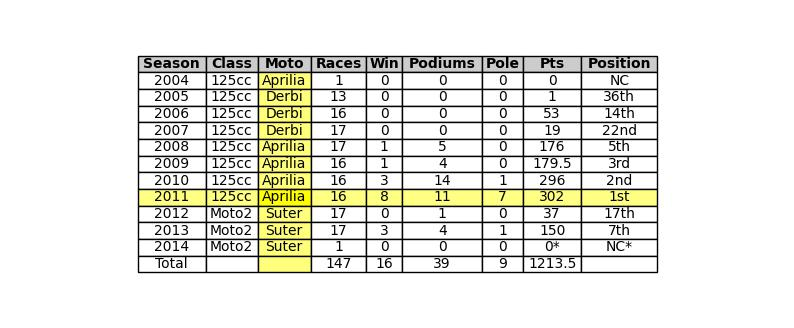

In [15]:
highlighted_table, original_table = generate_table_images(table1, score, cmap=custom_cmap)

def display_table(highlighted_table):
    # Base64 문자열을 디코딩
    image_data = base64.b64decode(highlighted_table)

    # 디코딩된 이미지를 BytesIO 객체로 변환
    image = io.BytesIO(image_data)

    # Jupyter Notebook에서 이미지 표시
    display(Image(data=image.read()))

display_table(highlighted_table)

### Evaluation

In [13]:
def answer_with_text(data):
    prompt = f"""
Answer the following question. Just give the answer, not the process.

Table: {data['table']}

Question: {data['question']}

Answer: 
"""
    answer = get_gpt(messages=[{'role':'user', 'content': prompt}], response_format = 'text')
    answer = answer.lower()
    return data['seq_out'] in answer

In [14]:
def get_gpt_messages(image, question):
    return [{
        "role": "user",
        "content": [
            {"type": "text", "text": "Answer the following question. Just give the answer, not the process. \nTable: "},
            {
                "type": "image_url",
                "image_url": {
                    "url" : f"data:image/jpeg;base64,{image}",
                    "detail" : 'auto'
                }
            },
            {"type": "text", "text": f"Question: {question}\nAnswer:"}
        ],
    }]


def get_gemini_messages(image, question):
    return [{"text": "Answer the following question. Just give the answer, not the process. \nTable: "},
            {
                "inline_data": {
                    "mime_type": "image/jpeg",
                    "data": image
                }
            },
            {"text": f"Question: {question}\nAnswer:"}]


            

In [15]:
def answer_with_image(data, model='gpt', plain=False, index=None, column_top_k=5, row_top_k=5):
    table = pd.DataFrame(data['table']['rows'], columns=data['table']['header'])
    score = get_table_score(table, data['question'], index=index, column_top_k=column_top_k, row_top_k=row_top_k)
    try:
        highlighted_table, original_table = generate_table_images(table, score, cmap=custom_cmap)
    except:
        print("Error in generating images", "index: ", index)
        return False, False
    
    if model == 'gpt':
        gpt_plain = get_gpt_messages(original_table, data['question'])
        gpt_highlighted = get_gpt_messages(highlighted_table, data['question'])

        # get ansnwer in parallel
        with ThreadPoolExecutor() as executor:
            if plain:
                answer1 = executor.submit(get_gpt, gpt_plain, response_format = 'text')
            answer2 = executor.submit(get_gpt, gpt_highlighted, response_format = 'text')
    elif model == 'gemini':
        gemini_plain = get_gemini_messages(original_table, data['question'])
        gemini_highlighted = get_gemini_messages(highlighted_table, data['question'])

        # get ansnwer in parallel
        with ThreadPoolExecutor() as executor:
            if plain:
                answer1 = executor.submit(get_gemini, gemini_plain)
            answer2 = executor.submit(get_gemini, gemini_highlighted)

    if plain:
        answer1 = str(answer1.result()).lower()
    else:
        answer1 = ""
    answer2 = str(answer2.result()).lower()

    return data['seq_out'] in answer1, data['seq_out'] in answer2

In [16]:
def evaluate_with_text(data, output_file='text_results.txt'):
    correct = 0
    with open(output_file, 'w') as file:
        for i in range(len(data)):
            is_correct = answer_with_text(data.iloc[i])
            if is_correct:
                correct += 1
            file.write(f'Row {i}: {is_correct}\n')
        file.write(f'Correct: {correct} ({correct / len(data)})')
    return correct / len(data)

def evaluate_with_image(data, output_file='image_results.txt', model='gpt', plain=False, offset=None, column_top_k=5, row_top_k=5):
    correct1 = 0
    correct2 = 0
    TF = 0
    FT = 0
    with open(output_file, 'w') as file:
        for i in range(len(data)):
            index = offset + i if offset is not None else None
            result1, result2 = answer_with_image(data.iloc[i], model=model, plain=plain, index=index, column_top_k=column_top_k, row_top_k=row_top_k)
            correct1 += result1
            correct2 += result2
            file.write(f'Row {i}: {result1}, {result2}\n')
            if result1 and not result2:
                TF += 1
            elif not result1 and result2:
                FT += 1
            print(f'Row {i}: {result1}, {result2}')
        file.write(f'Non-Highlight: {correct1} ({100*correct1 / len(data)}%) Highlight: {correct2} ({100*correct2 / len(data)}%)\n')
        file.write(f'TF: {TF}, FT: {FT}')
    return correct1 / len(data), correct2 / len(data)

In [17]:
def evaluate_with_image_parallel(data, output_file='image_results.txt', model='gpt', plain=False, offset=None, column_top_k=5, row_top_k=5, max_workers=4):
    def process_row(i, row):
        index = offset + i if offset is not None else None
        result1, result2 = answer_with_image(row, model=model, plain=plain, index=index, column_top_k=column_top_k, row_top_k=row_top_k)
        return i, result1, result2

    correct1 = 0
    correct2 = 0
    TF = 0
    FT = 0
    
    with open(output_file, 'w') as file, ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(process_row, i, data.iloc[i]): i for i in range(len(data))}
        
        for future in as_completed(futures):
            i, result1, result2 = future.result()
            correct1 += result1
            correct2 += result2
            file.write(f'Row {i}: {result1}, {result2}\n')
            
            if result1 and not result2:
                TF += 1
            elif not result1 and result2:
                FT += 1
        
        file.write(f'Non-Highlight: {correct1} ({100 * correct1 / len(data)}%) Highlight: {correct2} ({100 * correct2 / len(data)}%)\n')
        file.write(f'TF: {TF}, FT: {FT}\n')
        print(f'{offset} - {offset + len(data)}: Non-Highlight: {correct1} ({100 * correct1 / len(data)}%) Highlight: {correct2} ({100 * correct2 / len(data)}%)\n')
    
    return correct1 / len(data), correct2 / len(data)

In [18]:
# for i in range(600, 1000, 100):
#     print(evaluate_with_image_parallel(df_test[i:i+100], output_file=f'results/image_results_top_c1_r0_{i}_{i+99}.txt', offset=i, column_top_k=1, row_top_k=0, max_workers=4))
# for i in range(0, 1000, 100):
#     print(evaluate_with_image_parallel(df_test[i:i+100], output_file=f'results/image_results_top_c0_r1_{i}_{i+99}.txt', offset=i, column_top_k=0, row_top_k=1, max_workers=4))
# for i in range(100, 1000, 100):
#     print(evaluate_with_image_parallel(df_test[i:i+100], output_file=f'results/image_results_top_c1_r2_{i}_{i+99}.txt', offset=i, column_top_k=1, row_top_k=2, max_workers=4))
for i in range(400, 1000, 100):
    print(evaluate_with_image_parallel(df_test[i:i+100], output_file=f'results/image_results_top_c2_r1_{i}_{i+99}.txt', offset=i, column_top_k=2, row_top_k=1, max_workers=4))

/tmp/ipykernel_27061/232307282.py:62: UserWarning: Glyph 29233 (\N{CJK UNIFIED IDEOGRAPH-7231}) missing from font(s) DejaVu Sans.
  plt.savefig(img_buffer, format='jpeg', bbox_inches='tight', dpi=100)
/tmp/ipykernel_27061/232307282.py:62: UserWarning: Glyph 27665 (\N{CJK UNIFIED IDEOGRAPH-6C11}) missing from font(s) DejaVu Sans.
  plt.savefig(img_buffer, format='jpeg', bbox_inches='tight', dpi=100)
/tmp/ipykernel_27061/232307282.py:62: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from font(s) DejaVu Sans.
  plt.savefig(img_buffer, format='jpeg', bbox_inches='tight', dpi=100)
/tmp/ipykernel_27061/232307282.py:62: UserWarning: Glyph 19996 (\N{CJK UNIFIED IDEOGRAPH-4E1C}) missing from font(s) DejaVu Sans.
  plt.savefig(img_buffer, format='jpeg', bbox_inches='tight', dpi=100)
/tmp/ipykernel_27061/232307282.py:62: UserWarning: Glyph 23433 (\N{CJK UNIFIED IDEOGRAPH-5B89}) missing from font(s) DejaVu Sans.
  plt.savefig(img_buffer, format='jpeg', bbox_inches='tight', dpi=

400 - 500: Non-Highlight: 0 (0.0%) Highlight: 47 (47.0%)

(0.0, 0.47)
500 - 600: Non-Highlight: 0 (0.0%) Highlight: 50 (50.0%)

(0.0, 0.5)
600 - 700: Non-Highlight: 0 (0.0%) Highlight: 41 (41.0%)

(0.0, 0.41)
700 - 800: Non-Highlight: 0 (0.0%) Highlight: 47 (47.0%)

(0.0, 0.47)
800 - 900: Non-Highlight: 0 (0.0%) Highlight: 48 (48.0%)

(0.0, 0.48)


/tmp/ipykernel_27061/232307282.py:62: UserWarning: Glyph 34081 (\N{CJK UNIFIED IDEOGRAPH-8521}) missing from font(s) DejaVu Sans.
  plt.savefig(img_buffer, format='jpeg', bbox_inches='tight', dpi=100)
/tmp/ipykernel_27061/232307282.py:62: UserWarning: Glyph 21405 (\N{CJK UNIFIED IDEOGRAPH-539D}) missing from font(s) DejaVu Sans.
  plt.savefig(img_buffer, format='jpeg', bbox_inches='tight', dpi=100)
/tmp/ipykernel_27061/232307282.py:62: UserWarning: Glyph 28207 (\N{CJK UNIFIED IDEOGRAPH-6E2F}) missing from font(s) DejaVu Sans.
  plt.savefig(img_buffer, format='jpeg', bbox_inches='tight', dpi=100)
/tmp/ipykernel_27061/232307282.py:62: UserWarning: Glyph 21335 (\N{CJK UNIFIED IDEOGRAPH-5357}) missing from font(s) DejaVu Sans.
  plt.savefig(img_buffer, format='jpeg', bbox_inches='tight', dpi=100)
/tmp/ipykernel_27061/232307282.py:62: UserWarning: Glyph 23665 (\N{CJK UNIFIED IDEOGRAPH-5C71}) missing from font(s) DejaVu Sans.
  plt.savefig(img_buffer, format='jpeg', bbox_inches='tight', dpi=

900 - 1000: Non-Highlight: 0 (0.0%) Highlight: 52 (52.0%)

(0.0, 0.52)


In [18]:
# for i in range(100, 1000, 100):
#     print(evaluate_with_image_parallel(df_test[i:i+100], output_file=f'results_gemini/image_results_{i}_{i+99}.txt', plain=True, model='gemini', offset=i, column_top_k=100, row_top_k=100, max_workers=1))
for i in range(900, 1000, 100):
    print(evaluate_with_image_parallel(df_test[i:i+100], output_file=f'results_gemini/image_results_top_c1_r2_{i}_{i+99}.txt', model='gemini', offset=i, column_top_k=1, row_top_k=2, max_workers=1))
for i in range(0, 1000, 100):
    print(evaluate_with_image_parallel(df_test[i:i+100], output_file=f'results_gemini/image_results_top_c2_r1_{i}_{i+99}.txt', model='gemini', offset=i, column_top_k=2, row_top_k=1, max_workers=4))
for i in range(0, 1000, 100):
    print(evaluate_with_image_parallel(df_test[i:i+100], output_file=f'results_gemini/image_results_top_c2_r2_{i}_{i+99}.txt', model='gemini', offset=i, column_top_k=2, row_top_k=2, max_workers=4))
# for i in range(800, 1000, 100):
#     print(evaluate_with_image_parallel(df_test[i:i+100], output_file=f'results_gemini/image_results_top_c3_r1_{i}_{i+99}.txt', model='gemini', offset=i, column_top_k=3, row_top_k=1, max_workers=4))
# for i in range(0, 1000, 100):
#     print(evaluate_with_image_parallel(df_test[i:i+100], output_file=f'results_gemini/image_results_top_c3_r3_{i}_{i+99}.txt', model='gemini', offset=i, column_top_k=3, row_top_k=3, max_workers=4))
# for i in range(600, 1000, 100):
#     print(evaluate_with_image_parallel(df_test[i:i+100], output_file=f'results_gemini/image_results_top_c3_r5_{i}_{i+99}.txt', model='gemini', offset=i, column_top_k=3, row_top_k=5, max_workers=4))
# for i in range(0, 1000, 100):
#     print(evaluate_with_image_parallel(df_test[i:i+100], output_file=f'results_gemini/image_results_top_c5_r1_{i}_{i+99}.txt', model='gemini', offset=i, column_top_k=5, row_top_k=1, max_workers=4))
# for i in range(500, 1000, 100):
#     print(evaluate_with_image_parallel(df_test[i:i+100], output_file=f'results_gemini/image_results_top_c5_r3_{i}_{i+99}.txt', model='gemini', offset=i, column_top_k=5, row_top_k=3, max_workers=4))
# for i in range(900, 1000, 100):
#     print(evaluate_with_image_parallel(df_test[i:i+100], output_file=f'results_gemini/image_results_top_c5_r5_{i}_{i+99}.txt', model='gemini', offset=i, column_top_k=5, row_top_k=5, max_workers=4))

/tmp/ipykernel_28697/232307282.py:62: UserWarning: Glyph 34081 (\N{CJK UNIFIED IDEOGRAPH-8521}) missing from font(s) DejaVu Sans.
  plt.savefig(img_buffer, format='jpeg', bbox_inches='tight', dpi=100)
/tmp/ipykernel_28697/232307282.py:62: UserWarning: Glyph 21405 (\N{CJK UNIFIED IDEOGRAPH-539D}) missing from font(s) DejaVu Sans.
  plt.savefig(img_buffer, format='jpeg', bbox_inches='tight', dpi=100)
/tmp/ipykernel_28697/232307282.py:62: UserWarning: Glyph 28207 (\N{CJK UNIFIED IDEOGRAPH-6E2F}) missing from font(s) DejaVu Sans.
  plt.savefig(img_buffer, format='jpeg', bbox_inches='tight', dpi=100)
/tmp/ipykernel_28697/232307282.py:62: UserWarning: Glyph 21335 (\N{CJK UNIFIED IDEOGRAPH-5357}) missing from font(s) DejaVu Sans.
  plt.savefig(img_buffer, format='jpeg', bbox_inches='tight', dpi=100)
/tmp/ipykernel_28697/232307282.py:62: UserWarning: Glyph 23665 (\N{CJK UNIFIED IDEOGRAPH-5C71}) missing from font(s) DejaVu Sans.
  plt.savefig(img_buffer, format='jpeg', bbox_inches='tight', dpi=

900 - 1000: Non-Highlight: 0 (0.0%) Highlight: 58 (58.0%)

(0.0, 0.58)
0 - 100: Non-Highlight: 0 (0.0%) Highlight: 60 (60.0%)

(0.0, 0.6)
'content'
'content'
'content'
'content'
100 - 200: Non-Highlight: 0 (0.0%) Highlight: 58 (58.0%)

(0.0, 0.58)
200 - 300: Non-Highlight: 0 (0.0%) Highlight: 51 (51.0%)

(0.0, 0.51)
300 - 400: Non-Highlight: 0 (0.0%) Highlight: 63 (63.0%)

(0.0, 0.63)


/tmp/ipykernel_28697/232307282.py:62: UserWarning: Glyph 29233 (\N{CJK UNIFIED IDEOGRAPH-7231}) missing from font(s) DejaVu Sans.
  plt.savefig(img_buffer, format='jpeg', bbox_inches='tight', dpi=100)
/tmp/ipykernel_28697/232307282.py:62: UserWarning: Glyph 27665 (\N{CJK UNIFIED IDEOGRAPH-6C11}) missing from font(s) DejaVu Sans.
  plt.savefig(img_buffer, format='jpeg', bbox_inches='tight', dpi=100)
/tmp/ipykernel_28697/232307282.py:62: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from font(s) DejaVu Sans.
  plt.savefig(img_buffer, format='jpeg', bbox_inches='tight', dpi=100)
/tmp/ipykernel_28697/232307282.py:62: UserWarning: Glyph 19996 (\N{CJK UNIFIED IDEOGRAPH-4E1C}) missing from font(s) DejaVu Sans.
  plt.savefig(img_buffer, format='jpeg', bbox_inches='tight', dpi=100)
/tmp/ipykernel_28697/232307282.py:62: UserWarning: Glyph 23433 (\N{CJK UNIFIED IDEOGRAPH-5B89}) missing from font(s) DejaVu Sans.
  plt.savefig(img_buffer, format='jpeg', bbox_inches='tight', dpi=

'content'
'content'
400 - 500: Non-Highlight: 0 (0.0%) Highlight: 52 (52.0%)

(0.0, 0.52)
'content'
500 - 600: Non-Highlight: 0 (0.0%) Highlight: 56 (56.0%)

(0.0, 0.56)
600 - 700: Non-Highlight: 0 (0.0%) Highlight: 50 (50.0%)

(0.0, 0.5)
'content'
700 - 800: Non-Highlight: 0 (0.0%) Highlight: 59 (59.0%)

(0.0, 0.59)
800 - 900: Non-Highlight: 0 (0.0%) Highlight: 60 (60.0%)

(0.0, 0.6)


/tmp/ipykernel_28697/232307282.py:62: UserWarning: Glyph 34081 (\N{CJK UNIFIED IDEOGRAPH-8521}) missing from font(s) DejaVu Sans.
  plt.savefig(img_buffer, format='jpeg', bbox_inches='tight', dpi=100)
/tmp/ipykernel_28697/232307282.py:62: UserWarning: Glyph 21405 (\N{CJK UNIFIED IDEOGRAPH-539D}) missing from font(s) DejaVu Sans.
  plt.savefig(img_buffer, format='jpeg', bbox_inches='tight', dpi=100)
/tmp/ipykernel_28697/232307282.py:62: UserWarning: Glyph 28207 (\N{CJK UNIFIED IDEOGRAPH-6E2F}) missing from font(s) DejaVu Sans.
  plt.savefig(img_buffer, format='jpeg', bbox_inches='tight', dpi=100)
/tmp/ipykernel_28697/232307282.py:62: UserWarning: Glyph 21335 (\N{CJK UNIFIED IDEOGRAPH-5357}) missing from font(s) DejaVu Sans.
  plt.savefig(img_buffer, format='jpeg', bbox_inches='tight', dpi=100)
/tmp/ipykernel_28697/232307282.py:62: UserWarning: Glyph 23665 (\N{CJK UNIFIED IDEOGRAPH-5C71}) missing from font(s) DejaVu Sans.
  plt.savefig(img_buffer, format='jpeg', bbox_inches='tight', dpi=

900 - 1000: Non-Highlight: 0 (0.0%) Highlight: 58 (58.0%)

(0.0, 0.58)
0 - 100: Non-Highlight: 0 (0.0%) Highlight: 62 (62.0%)

(0.0, 0.62)
'content'
'content'
'content'
100 - 200: Non-Highlight: 0 (0.0%) Highlight: 58 (58.0%)

(0.0, 0.58)


: 